In [8]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
import re
plt.rcParams["svg.fonttype"] = "none"
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import itertools
from statsmodels.stats.proportion import proportions_ztest
pd.set_option('display.max_columns', None)

In [12]:
uniprot_names_and_weights = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/uniprot_reviewed_multiple_data/uniprotkb_taxonomy_id_10090_AND_reviewe_2024_11_26.tsv', sep='\t')

uniprot_names_and_weights = uniprot_names_and_weights.rename(columns={"Mass": "Mass (Da)"})

def calculate_disordered_ratio(df):
    print('Disordered')
    def parse_disordered_length(row):
        region_info = row['Region']
        if pd.isna(region_info) or not isinstance(region_info, str):
            return 0
        ranges = re.findall(r'(\d+)\.\.(\d+); /note="Disordered"', region_info)
        total_length = sum(int(end) - int(start) + 1 for start, end in ranges)
        return total_length
    
    df['Disordered Ratio'] = df.apply(lambda row: parse_disordered_length(row) / row['Length'] if row['Length'] != 0 else 0, axis=1)
    return df

uniprot_data_with_mass_and_longest = calculate_disordered_ratio(uniprot_names_and_weights)
uniprot_data_with_mass_and_longest

Disordered


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Region,Compositional bias,Domain [CC],Domain [FT],Coiled coil,Motif,Post-translational modification,Signal peptide,Transit peptide,Glycosylation,Intramembrane,Subcellular location [CC],Transmembrane,Topological domain,Mass (Da),ComplexPortal,CORUM,BioGRID,DIP,ELM,IntAct,MINT,STRING,Disordered Ratio
0,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"REGION 1..88; /note=""Disordered""; /evidence=""E...","COMPBIAS 45..61; /note=""Polar residues""; /evid...",DOMAIN: The Pro-rich region is important for t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,138920,NaN,NaN,NaN,NaN,NaN,A0A087WPF7; 23.;,A0A087WPF7;,10090.ENSMUSP00000139759;,0.665345
1,A0A088MLT8,reviewed,IQIP1_MOUSE,IQCJ-SCHIP1 readthrough transcript protein,Iqcj-Schip1 Iqschfp Schip1,Mus musculus (Mouse),559,"REGION 64..141; /note=""Disordered""; /evidence=...","COMPBIAS 69..97; /note=""Polar residues""; /evid...",NaN,"DOMAIN 47..67; /note=""IQ""","COILED 496..530; /evidence=""ECO:0000255""",NaN,NaN,NaN,NaN,NaN,NaN,"SUBCELLULAR LOCATION: Cell projection, axon {E...",NaN,NaN,61917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000138212;,0.502683
2,A0A0B4J1F4,reviewed,ARRD4_MOUSE,Arrestin domain-containing protein 4,Arrdc4,Mus musculus (Mouse),415,NaN,NaN,NaN,NaN,NaN,"MOTIF 347..350; /note=""PPxY motif 1""; /evidenc...",NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,NaN,NaN,44970,NaN,NaN,NaN,NaN,NaN,A0A0B4J1F4; 1.;,NaN,10090.ENSMUSP00000044578;,0.000000
3,A0A0B4J1G0,reviewed,FCG3A_MOUSE,Low affinity immunoglobulin gamma Fc region re...,Fcgr4 Fcgr3a,Mus musculus (Mouse),249,NaN,NaN,NaN,"DOMAIN 22..102; /note=""Ig-like C2-type 1""; /ev...",NaN,NaN,PTM: N-glycosylated. {ECO:0000269|PubMed:16039...,"SIGNAL 1..20; /evidence=""ECO:0000255""",NaN,"CARBOHYD 62; /note=""N-linked (GlcNAc...) aspar...",NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,"TRANSMEM 204..224; /note=""Helical""; /evidence=...","TOPO_DOM 21..203; /note=""Extracellular""; /evid...",28398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000077873;,0.000000
4,A0A0B4J1N3,reviewed,GP15L_MOUSE,Protein GPR15LG (Protein GPR15 ligand) (Protei...,Gpr15lg Gpr15l,Mus musculus (Mouse),78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SIGNAL 1..24; /evidence=""ECO:0000250|UniProtKB...",NaN,NaN,NaN,SUBCELLULAR LOCATION: Secreted {ECO:0000250|Un...,NaN,NaN,8899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000136426;,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17223,Q9JJR6,reviewed,CK016_MOUSE,Uncharacterized protein C11orf16 homolog,D7h11orf16,Mus musculus (Mouse),402,"REGION 332..402; /note=""Disordered""; /evidence...","COMPBIAS 363..380; /note=""Polar residues""; /ev...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176617
17224,Q9JJR9,reviewed,NRIP3_MOUSE,Nuclear receptor-interacting protein 3,Nrip3 D7H11orf14,Mus musculus (Mouse),240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26879,NaN,NaN,219504; 27.;,NaN,NaN,Q9JJR9; 27.;,NaN,10090.ENSMUSP00000033331;,0.000000
17225,Q9WUQ7,reviewed,DEXI_MOUSE,Dexamethasone-induced protein (Protein MYLE),Dexi Myle,Mus musculus (Mouse),95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000139108;,0.000000
17226,Q9WVB6,reviewed,LENEP_MOUSE,Lens epithelial cell protein LEP503,Lenep Lep503,Mus musculus (Mouse),61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000052968;,0.000000


In [13]:
picnic_df = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/picnic_data/PICNIC-10090-data.csv')
picnic_df = picnic_df[(picnic_df['Genes'].apply(lambda x: isinstance(x, str)))]

uniprot_data_with_mass_and_longest_and_picnic = pd.merge(uniprot_data_with_mass_and_longest, picnic_df, left_on='Gene Names', right_on='Genes', how='left')
for column in uniprot_data_with_mass_and_longest_and_picnic.columns:
    print(column)   

Entry
Reviewed
Entry Name
Protein names
Gene Names
Organism_x
Length
Region
Compositional bias
Domain [CC]
Domain [FT]
Coiled coil
Motif
Post-translational modification
Signal peptide
Transit peptide
Glycosylation
Intramembrane
Subcellular location [CC]
Transmembrane
Topological domain
Mass (Da)
ComplexPortal
CORUM
BioGRID
DIP
ELM
IntAct
MINT
STRING
Disordered Ratio
ID
PICNIC score
PICNIC GO score
Uniprot ID
Proteins
Genes
Organism_y
Organism ID
CD-Code included


In [16]:
smoops = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/masterfile/all_smOOPS_and_controls_V2.tsv', sep='\t')
smoops['smoops_common'] = ~smoops['control_common']
clusters = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Results/machine_learning_results/cluster_assignment_file/cluster_of_all_model.tsv', sep='\t')
smoops_clusters = pd.merge(smoops, clusters, left_on='transcript_id', right_on='transcript_id', how='left')

smoops_clusters['cluster_0'] = smoops_clusters['Cluster'] == 0
smoops_clusters['cluster_1'] = smoops_clusters['Cluster'] == 1

smoops_common_set = set(smoops_clusters[smoops_clusters['smoops_common'] == True]['gene_name'])
print("smoops_common_set", len(smoops_common_set))

smoops_cluster0_set = set(smoops_clusters[smoops_clusters['cluster_0'] == True]['gene_name'])
print("smoops_cluster0_set", len(smoops_cluster0_set))
smoops_cluster1_set = set(smoops_clusters[smoops_clusters['cluster_1'] == True]['gene_name'])
print("smoops_cluster1_set", len(smoops_cluster1_set))

smoops_common_set 1828
smoops_cluster0_set 1064
smoops_cluster1_set 760


In [17]:
semi_naive_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/semi_naive_vs_control_naive_deseq.tsv', sep="\t")

expressed_genes_set = set(semi_naive_deseq['gene_id'])
print("length of expressed_genes_set: ", len(expressed_genes_set))

transcript_data = []

with open('/ceph/hpc/home/novljanj/data_storage/genomes/genome_m39/gencode.vM27.chr_patch_hapl_scaff.annotation.gtf', 'r') as gtf_file:
    for line in gtf_file:
        if line.startswith('#'):
            continue

        columns = line.strip().split('\t')
        attributes = columns[8]

        if 'transcript_id' in attributes:
            gene_name = [field for field in attributes.split(';') if 'gene_name' in field][0]
            gene_name = gene_name.split('"')[1]
            gene_id = [field for field in attributes.split(';') if 'gene_id' in field][0]
            gene_id = gene_id.split('"')[1]
            transcript_id = [field for field in attributes.split(';') if 'transcript_id' in field][0]
            transcript_id = transcript_id.split('"')[1]
            gene_type = [field for field in attributes.split(';') if 'gene_type' in field][0]
            gene_type = gene_type.split('"')[1]

            transcript_data.append(columns[:7] + [gene_id] + [gene_name] + [transcript_id] + [gene_type])

column_names = ['seqname', 'source', 'feature', 'start', 'end', 'score', "strand", "gene_id", "gene_name", 'transcript_id', 'gene_type']

annotation = pd.DataFrame(transcript_data, columns=column_names)
annotation['start'] = annotation['start'].astype(int) - 1
annotation = annotation[annotation['feature'] == 'transcript']

gene_id_to_name = dict(zip(annotation['gene_id'], annotation['gene_name']))

expressed_gene_names_set = set([gene_id_to_name[gene_id] for gene_id in expressed_genes_set])
expressed_gene_names_set

length of expressed_genes_set:  16484


{'Eno2',
 'Plekho2',
 'H2bc23',
 'Raly',
 'Rock1',
 'Mrpl48',
 'Cdc27',
 'Wnt7b',
 'Nras',
 'Syde1',
 'Eif1a',
 'Hrc',
 'Cacna2d2',
 'Gm15148',
 'Lrfn1',
 'Exoc8',
 'Ranbp9',
 'Gart',
 'Ceacam1',
 'Emilin1',
 'Gm37238',
 'Acap2',
 'Tspan12',
 'Washc2',
 'Ccdc102a',
 'Ttll3',
 'Gm11970',
 'Stmn3',
 'Gm38104',
 'Pex16',
 'Gm7266',
 'Otulinl',
 'Prr19',
 'Dnah7a',
 'Dck',
 'Immp1l',
 'Cphx1',
 'Chd2',
 'Gm43430',
 'Tceal9',
 'Trim26',
 'Slc66a2',
 'Tfeb',
 'Pot1a',
 'Sec23ip',
 'Cdk2',
 'Gm8231',
 'Ddost',
 '5033406O09Rik',
 'Ppid',
 'Slc48a1',
 'Fkbp1a',
 'Llgl1',
 'Gramd2',
 'Gm15310',
 'Zfp114',
 '4833420G17Rik',
 'Tex261',
 '4930539J05Rik',
 'Gm44503',
 'Plk5',
 'Cpeb4',
 'Clybl',
 'Zbtb24',
 'Znrd2',
 'Ercc6l2',
 'Snora23',
 'Foxd2os',
 'Gm14393',
 'Mymx',
 'Tead4',
 'Ccdc85b',
 'Ddx58',
 'Arl10',
 'Tubgcp4',
 'Ftx',
 'Foxa3',
 'Strn4',
 'Anxa2',
 'Gm38257',
 'Tesc',
 'Gm38336',
 'A730011C13Rik',
 'Mrpl38',
 '5830417I10Rik',
 'Crebzf',
 'Gan',
 'Gm43329',
 '9030407P20Rik',
 'Ttc13',


In [19]:
def mark_genes_in_set(df, gene_set, gene_set_name):

    def is_gene_in_set(gene_names_str):
        gene_names_str = str(gene_names_str)
        gene_names = gene_names_str.split()
        return any(gene in gene_set for gene in gene_names)
    
    df[gene_set_name] = df['Gene Names'].apply(is_gene_in_set)
    
    return df

list_of_sets = [smoops_common_set, smoops_cluster0_set, smoops_cluster1_set, expressed_gene_names_set]
list_of_set_names = ['smoops_common','smoops_cluster0', 'smoops_cluster1', 'expressed_genes']

for gene_set, gene_set_name in zip(list_of_sets, list_of_set_names):
    uniprot_data_with_mass_and_longest_and_picnic = mark_genes_in_set(uniprot_data_with_mass_and_longest_and_picnic, gene_set, gene_set_name)
    print(gene_set_name, len(uniprot_data_with_mass_and_longest_and_picnic[uniprot_data_with_mass_and_longest_and_picnic[gene_set_name] == True]))
    
uniprot_data_with_mass_and_longest_and_picnic = uniprot_data_with_mass_and_longest_and_picnic[uniprot_data_with_mass_and_longest_and_picnic["expressed_genes"] == True]

uniprot_data_with_mass_and_longest_and_picnic['control_all'] = ~uniprot_data_with_mass_and_longest_and_picnic['smoops_common']
uniprot_data_with_mass_and_longest_and_picnic

smoops_common 1201
smoops_cluster0 961
smoops_cluster1 239
expressed_genes 11839


/tmp/ipykernel_204535/1247461404.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_data_with_mass_and_longest_and_picnic['control_all'] = ~uniprot_data_with_mass_and_longest_and_picnic['smoops_common']


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism_x,Length,Region,Compositional bias,Domain [CC],Domain [FT],Coiled coil,Motif,Post-translational modification,Signal peptide,Transit peptide,Glycosylation,Intramembrane,Subcellular location [CC],Transmembrane,Topological domain,Mass (Da),ComplexPortal,CORUM,BioGRID,DIP,ELM,IntAct,MINT,STRING,Disordered Ratio,ID,PICNIC score,PICNIC GO score,Uniprot ID,Proteins,Genes,Organism_y,Organism ID,CD-Code included,smoops_common,smoops_cluster0,smoops_cluster1,expressed_genes,control_all
0,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"REGION 1..88; /note=""Disordered""; /evidence=""E...","COMPBIAS 45..61; /note=""Polar residues""; /evid...",DOMAIN: The Pro-rich region is important for t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,138920,NaN,NaN,NaN,NaN,NaN,A0A087WPF7; 23.;,A0A087WPF7;,10090.ENSMUSP00000139759;,0.665345,A0A087WPF7,0.774435,0.387744,A0A087WPF7,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),10090.0,False,False,False,False,True,True
1,A0A088MLT8,reviewed,IQIP1_MOUSE,IQCJ-SCHIP1 readthrough transcript protein,Iqcj-Schip1 Iqschfp Schip1,Mus musculus (Mouse),559,"REGION 64..141; /note=""Disordered""; /evidence=...","COMPBIAS 69..97; /note=""Polar residues""; /evid...",NaN,"DOMAIN 47..67; /note=""IQ""","COILED 496..530; /evidence=""ECO:0000255""",NaN,NaN,NaN,NaN,NaN,NaN,"SUBCELLULAR LOCATION: Cell projection, axon {E...",NaN,NaN,61917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000138212;,0.502683,A0A088MLT8,0.636872,0.548429,A0A088MLT8,IQCJ-SCHIP1 readthrough transcript protein,Iqcj-Schip1 Iqschfp Schip1,Mus musculus (Mouse),10090.0,False,False,False,False,True,True
2,A0A0B4J1F4,reviewed,ARRD4_MOUSE,Arrestin domain-containing protein 4,Arrdc4,Mus musculus (Mouse),415,NaN,NaN,NaN,NaN,NaN,"MOTIF 347..350; /note=""PPxY motif 1""; /evidenc...",NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,NaN,NaN,44970,NaN,NaN,NaN,NaN,NaN,A0A0B4J1F4; 1.;,NaN,10090.ENSMUSP00000044578;,0.000000,A0A0B4J1F4,0.206111,0.240662,A0A0B4J1F4,Arrestin domain-containing protein 4,Arrdc4,Mus musculus (Mouse),10090.0,False,False,False,False,True,True
8,A0A140LIF8,reviewed,IRGM2_MOUSE,Immunity-related GTPase family M protein 2 (EC...,Irgm2 Iigp2,Mus musculus (Mouse),395,NaN,NaN,NaN,"DOMAIN 63..239; /note=""IRG-type G""; /evidence=...",NaN,NaN,PTM: Ubiquitinated; polyubiquitinated in the c...,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Cytoplasmic vesicle memb...,NaN,NaN,45205,NaN,NaN,NaN,NaN,NaN,A0A140LIF8; 1.;,NaN,10090.ENSMUSP00000056001;,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True
10,A0A1W2P872,reviewed,NOVA2_MOUSE,RNA-binding protein Nova-2,Nova2,Mus musculus (Mouse),492,NaN,NaN,DOMAIN: The third KH domain (KH3) recognizes s...,"DOMAIN 32..99; /note=""KH 1""; /evidence=""ECO:00...",NaN,"MOTIF 10..26; /note=""Bipartite nuclear localiz...",NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,49067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000151939;,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17214,Q9DAC7,reviewed,TTC32_MOUSE,Tetratricopeptide repeat protein 32 (TPR repea...,Ttc32,Mus musculus (Mouse),148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000082891;,0.000000,Q9DAC7,0.511566,NaN,Q9DAC7,Tetratricopeptide repeat protein 32 (TPR repea...,Ttc32,Mus musculus (Mouse),10090.0,False,False,False,False,True,True
17221,Q9DB54,reviewed,F216A_MOUSE,Protein FAM216A,Fam216a,Mus musculus (Mouse),251,"REGION 1..41; /note=""Disordered""; /evidence=""E...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28339,NaN,Na

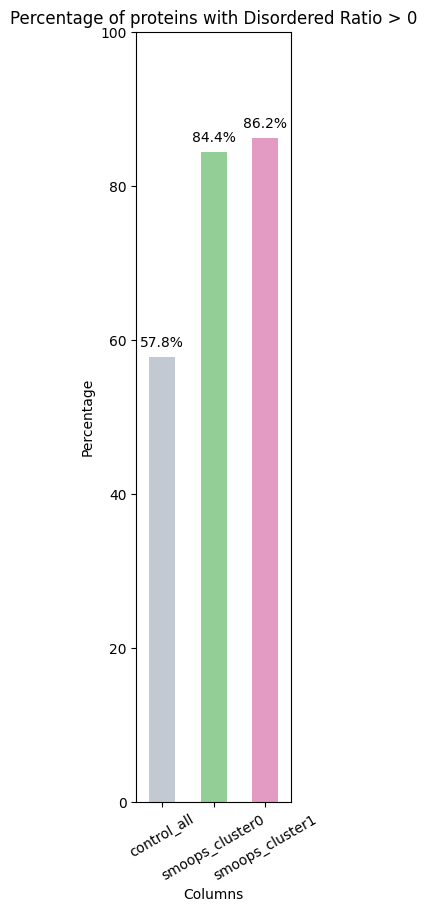

Comparison control_all vs smoops_cluster0: Z-stat = -16.128776922095717, p-value = 1.6016087873082236e-58
Comparison control_all vs smoops_cluster1: Z-stat = -8.814940245386659, p-value = 1.1974891276789881e-18
Comparison smoops_cluster0 vs smoops_cluster1: Z-stat = -0.6931535922254386, p-value = 0.4882131682851609
Chi-square statistic: 328.6556, p-value: 0.0000
Significant difference in disorder percentages between groups.


In [20]:
def plot_true_percentage(df, true_columns, value_column):
    percentages = []
    for col in true_columns:
        true_values = df[df[col] == True]
        percentage = (true_values[value_column] > 0).mean()*100
        percentages.append(percentage)
        
    plt.figure(figsize=(2, 10))
    bars = plt.bar(true_columns, percentages, color=['#C3C9D3', '#94CE97', '#E39BC4'], width=0.5)
    plt.xlabel("Columns")
    plt.ylabel("Percentage")
    plt.title(f"Percentage of proteins with {value_column} > 0")
    
    for bar, percentage in zip(bars, percentages):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{percentage:.1f}%', ha='center', va='bottom')
    plt.xticks(rotation=30)
    
    plt.ylim(0, 100)
    plt.xlim(-0.5, len(true_columns)-0.5)
    plt.show()

def compare_z_test(df, true_columns, value_column):
    results = {}

    for col1, col2 in itertools.combinations(true_columns, 2):
        group1 = df[df[col1] == True]
        group2 = df[df[col2] == True]

        count = [(group1[value_column] > 0).sum(), (group2[value_column] > 0).sum()]
        nobs = [len(group1), len(group2)]

        z_stat, p_value = proportions_ztest(count, nobs)
        results[(col1, col2)] = p_value
        print(f"Comparison {col1} vs {col2}: Z-stat = {z_stat}, p-value = {p_value}")

    return results

def compare_chi_square(df, true_columns, value_column):
    contingency_table = []

    for col in true_columns:
        group = df[df[col] == True]
        disorder = (group[value_column] > 0).sum()
        non_disorder = len(group) - disorder
        contingency_table.append([disorder, non_disorder])

    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-square statistic: {chi2:.4f}, p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Significant difference in disorder percentages between groups.")
    else:
        print("No significant difference between groups.")

features = ["Disordered Ratio",
            ]

for feature in features:
    plot_true_percentage(uniprot_data_with_mass_and_longest_and_picnic, ["control_all", "smoops_cluster0",	"smoops_cluster1"], feature)


compare_z_test(uniprot_data_with_mass_and_longest_and_picnic, ["control_all", "smoops_cluster0",	"smoops_cluster1"], "Disordered Ratio")
compare_chi_square(uniprot_data_with_mass_and_longest_and_picnic, ["control_all", "smoops_cluster0",	"smoops_cluster1"], "Disordered Ratio")

/tmp/ipykernel_204535/620770146.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Disordered Bin"] = pd.cut(df["Disordered Ratio"], bins=bins, labels=labels, include_lowest=False)
/tmp/ipykernel_204535/620770146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PICNIC Bin"] = pd.cut(df["PICNIC score"], bins=bins, labels=labels, include_lowest=False)
/tmp/ipykernel_204535/620770146.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of

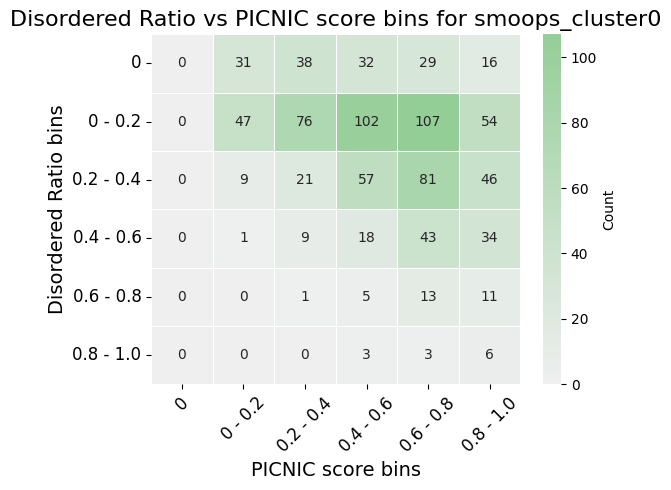

/tmp/ipykernel_204535/620770146.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Disordered Bin"] = pd.cut(df["Disordered Ratio"], bins=bins, labels=labels, include_lowest=False)
/tmp/ipykernel_204535/620770146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PICNIC Bin"] = pd.cut(df["PICNIC score"], bins=bins, labels=labels, include_lowest=False)
/tmp/ipykernel_204535/620770146.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of

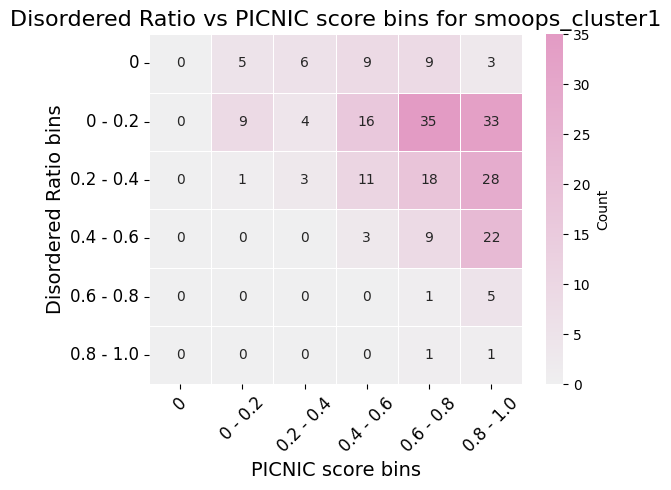

In [21]:
def stratify_and_plot_heatmap(df, column_name):
    df = df[df[column_name] == True]

    bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ["0", "0 - 0.2", "0.2 - 0.4", "0.4 - 0.6", "0.6 - 0.8", "0.8 - 1.0"]

    df["Disordered Bin"] = pd.cut(df["Disordered Ratio"], bins=bins, labels=labels, include_lowest=False)
    df["PICNIC Bin"] = pd.cut(df["PICNIC score"], bins=bins, labels=labels, include_lowest=False)

    heatmap_data = (
        df.groupby(["Disordered Bin", "PICNIC Bin"])
        .size()
        .unstack(fill_value=0)
    )

    if column_name == 'smoops_cluster0':
        colors_cmap = ['#EFEFF0', '#94CE97']
    elif column_name == 'smoops_cluster1':
        colors_cmap = ['#EFEFF0', '#E39BC4']

    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_cmap, N=256)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
    )

    plt.title(f"Disordered Ratio vs PICNIC score bins for {column_name}", fontsize=16)
    plt.xlabel("PICNIC score bins", fontsize=14)
    plt.ylabel("Disordered Ratio bins", fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

stratify_and_plot_heatmap(uniprot_data_with_mass_and_longest_and_picnic, 'smoops_cluster0')
stratify_and_plot_heatmap(uniprot_data_with_mass_and_longest_and_picnic, 'smoops_cluster1')

All data points:  11839
Data points with non-NaN values:  11839
control_all: 10638 data points, mean = 0.05
smoops_cluster0: 961 data points, mean = 0.07
control_all vs smoops_cluster0: p-value = 2.9483093496709245e-30
control_all: 10638 data points, mean = 0.05
smoops_cluster1: 239 data points, mean = 0.08
control_all vs smoops_cluster1: p-value = 7.412991520606524e-14


/tmp/ipykernel_204535/2948768245.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)
/tmp/ipykernel_204535/2948768245.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['control_all', 'smoops_cluster0', 'smoops_cluster1'])


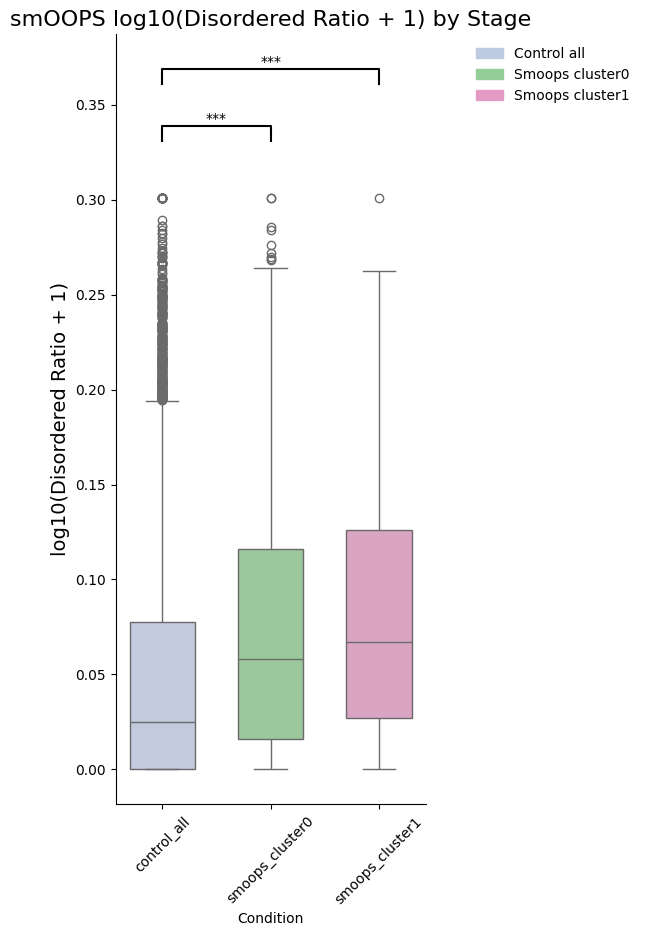

All data points:  11839
Data points with non-NaN values:  11839
control_all: 10638 data points, mean = 4.68
smoops_cluster0: 961 data points, mean = 5.06
control_all vs smoops_cluster0: p-value = 1.0807224572286063e-223
control_all: 10638 data points, mean = 4.68
smoops_cluster1: 239 data points, mean = 4.99
control_all vs smoops_cluster1: p-value = 7.58959880065342e-48


/tmp/ipykernel_204535/2948768245.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)
/tmp/ipykernel_204535/2948768245.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['control_all', 'smoops_cluster0', 'smoops_cluster1'])


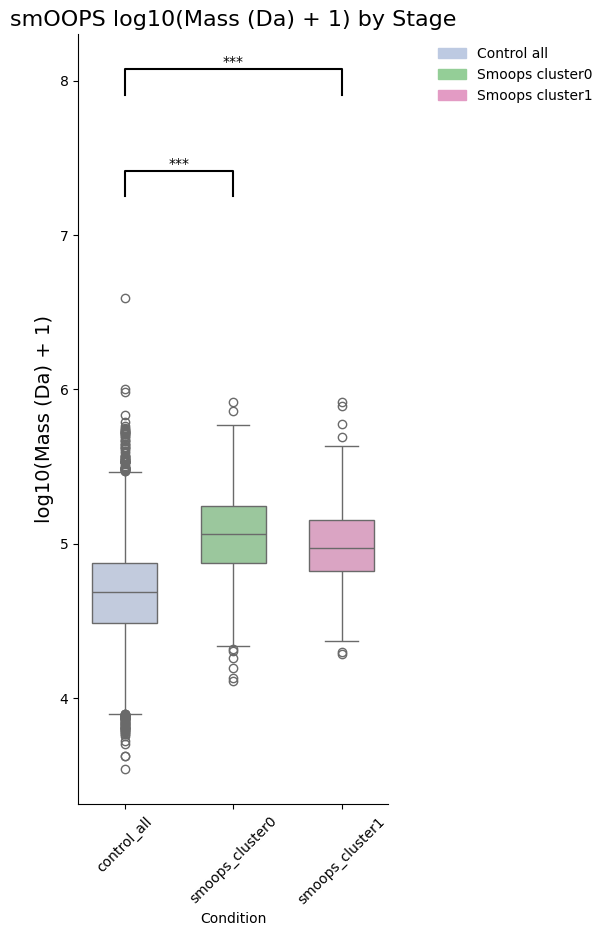

All data points:  11839
Data points with non-NaN values:  11556
control_all: 10431 data points, mean = 0.17
smoops_cluster0: 893 data points, mean = 0.19
control_all vs smoops_cluster0: p-value = 7.104366751013193e-17
control_all: 10431 data points, mean = 0.17
smoops_cluster1: 232 data points, mean = 0.22
control_all vs smoops_cluster1: p-value = 1.6784879857280357e-31


/tmp/ipykernel_204535/2948768245.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)
/tmp/ipykernel_204535/2948768245.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['control_all', 'smoops_cluster0', 'smoops_cluster1'])


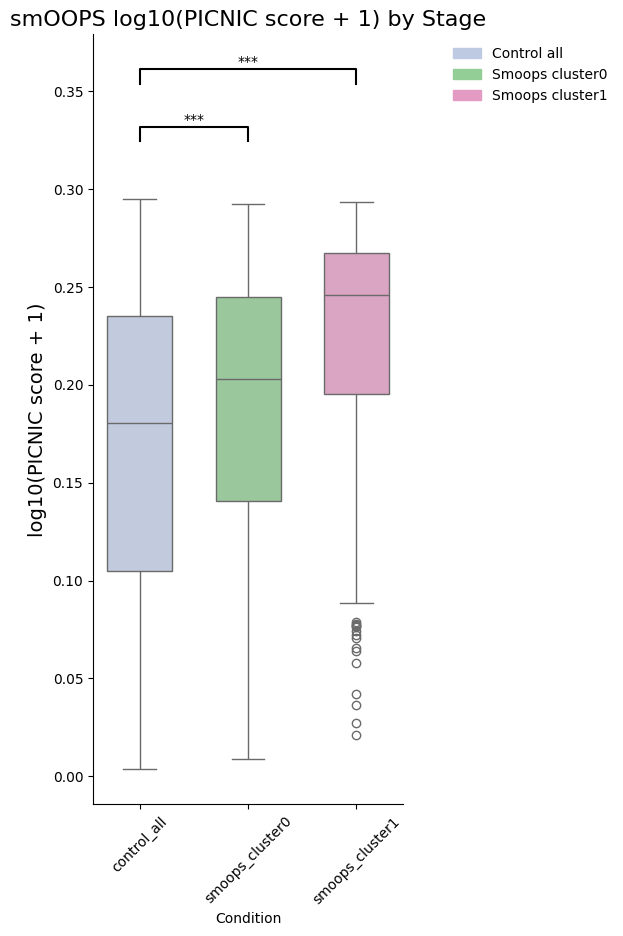

In [22]:
def plot_boxplot(df, column, log=False, stat_test = 'ttest'):
    try:
        print("All data points: ", len(df))
        df = df.copy()
        df = df[df[column].notna()]
        df[column] = df[column].astype(float)

        if log:
            df[f'log10({column} + 1)'] = np.log10(df[column]+ 1)
            column = f'log10({column} + 1)'
            
        print("Data points with non-NaN values: ", len(df))

        conditions = ['control_all', 'smoops_cluster0', 'smoops_cluster1']
        filtered_data = pd.DataFrame({
            condition: df[df[condition] == True][column] for condition in conditions
        })
        melted_data = filtered_data.melt(var_name='Condition', value_name=column)
        
        
        comparisons = [('control_all', 'smoops_cluster0'), ('control_all', 'smoops_cluster1')]
        results = []
        for test_a, test_b in comparisons:
            test_a_data = filtered_data[test_a].dropna().to_list()
            test_b_data = filtered_data[test_b].dropna().to_list()
            print(f'{test_a}: {len(test_a_data)} data points, mean = {np.mean(test_a_data):.2f}')
            print(f'{test_b}: {len(test_b_data)} data points, mean = {np.mean(test_b_data):.2f}')
            if stat_test == 'ttest':
                stat, p_val = ttest_ind(test_a_data, test_b_data, equal_var=False)
            elif stat_test == 'mannwhitneyu':
                stat, p_val = mannwhitneyu(test_a_data, test_b_data)
            print(f'{test_a} vs {test_b}: p-value = {p_val}')
            results.append((test_a, test_b, p_val))

        hex_palette = {'control_all': '#bdcae2', 'smoops_cluster0': '#94CE97', 'smoops_cluster1': '#E39BC4'}
        
        plt.figure(figsize=(4, 10))

        ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)    
        
        y_max = melted_data[column].max() * 1.10
        
        y_step = y_max / 11 

        for idx, (test_a, test_b, p_val) in enumerate(results):
            x1, x2 = conditions.index(test_a), conditions.index(test_b)
            y, h = y_max + idx * y_step, y_step / 4
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color='black')
        
        plt.title(f'smOOPS {column} by Stage', fontsize=16)
        plt.ylabel(f'{column}', fontsize=14)
        plt.xticks(rotation=45)

        ax.set_xticklabels(['control_all', 'smoops_cluster0', 'smoops_cluster1'])

        legend_elements = [mpatches.Patch(color=hex_palette[name], label=name.replace('_', ' ').capitalize()) for name in hex_palette]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.7, 1), frameon=False)

        sns.despine()
        plt.show()

    except Exception as e:
        print(e)

features = ["Disordered Ratio",
            "Mass (Da)",
            "PICNIC score"
            ]

for feature in features:

    if feature == "Mass (Da)":
        log = True
    if feature == "Mass (Da)" or feature == "PICNIC score":
        stat_test = 'ttest'
    else:
        stat_test = 'mannwhitneyu'
        
    plot_boxplot(uniprot_data_with_mass_and_longest_and_picnic, column=feature, log=True)